<a href="https://colab.research.google.com/github/pfedu/contour_detection/blob/main/contour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このノートブックでは、プログラミング教材 [Playgram](https://playgram.jp/) 公式サイトのブログ記事[「タイピングのお手本画像をプログラムに作らせる」](https://playgram.jp/blog/developer/generate-typing-assets/)で紹介
した**写真からプレイグラムタイピングのお手本画像を生成する**プログラムを、皆さん自身の手で体験することができます。

Google Colaboratory の使い方が分からない方は、[こちらの記事](https://playgram.jp/oshiete-pfn/google-colaboratory/)も併せてご覧ください。

## 0. ライブラリの読み込み
最初に、今回の作業で使うライブラリと関数を読み込みます。コードの左肩の **\[　\]** の部分にカーソルを当てると出てくる**右向きの三角形（実行ボタン）**を押してください。

In [1]:
from base64 import b64decode
import platform

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2

from google import colab
from google.colab.output import eval_js
from IPython.display import display, Javascript

# Colaboratory 上でカメラ撮影する関数
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '撮影';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# 画像を Colaboratory に読み込む
def load_image(path, scale):
    img = cv2.imread(path)
    img = cv2.resize(img, dsize=(0, 0), fx=scale, fy=scale)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB 色空間に変換
    return img

print('Python:     {}'.format(platform.python_version()))
print('NumPy:      {}'.format(np.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('OpenCV:     {}'.format(cv2.__version__))

Python:     3.7.10
NumPy:      1.19.5
Matplotlib: 3.2.2
OpenCV:     4.1.2


## 1. 手指を撮影する
あなたの端末についているカメラで手指を撮影して Colaboratory にアップロードしましょう。実行ボタンを押すと「撮影」ボタンが出てくるので撮影してください（ブラウザからカメラの使用許可を求められた場合は「許可する」を押してください）。

撮影の際は、次の工程で手指の部分をくり抜きやすくするため、背景に**緑色の布**を置いて撮るようにしてください。

In [ ]:
# カメラで撮影する
src_path = take_photo()

print('Uploaded: {}'.format(src_path))
src = load_image(src_path, scale=1.0)
plt.imshow(src)

あるいは、すでに手指を撮影した写真を持っている場合は、以下のコードを使ってアップロードしてください。実行ボタンを押すと出てくる「参照」ボタンをクリックして、端末の中からアップロードする画像を選びます。

**【注意】**すでにカメラ撮影で画像を取り込んでいる場合は、以下のコードを実行するとすでに読み込んだ画像が上書きされてしまいます。実行しないでください。また、同じ名前で別の画像をアップロードしても反映されないので、毎回ファイル名を変えて下さい。

Saving hand.png to hand.png
Uploaded: hand.png


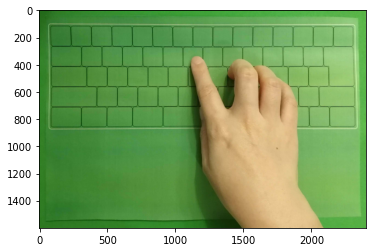

In [2]:
# 端末からアップロードする
uploaded_files = colab.files.upload()
src_path = next(iter(uploaded_files))

print('Uploaded: {}'.format(src_path))
src = load_image(src_path, scale=1.0)
plt.imshow(src)

## 2. 手指をくり抜く
Colaboratory に取り込んだ写真に前処理を施して、手指以外の部分を取り除いた画像 (`prep`) を作ります。ここでうまく手指の部分をくり抜くことができれば、後工程の仕上がりがキレイになります。

ここでは、画像の[色空間](https://ja.wikipedia.org/wiki/%E8%89%B2%E7%A9%BA%E9%96%93)を RGB から [YCrCb](https://ja.wikipedia.org/wiki/YUV) に変換してから `inRange` 関数で手指の色に対応した部分のみを抽出したマスクを作成し、それを元画像に合成して手指をくり抜きます。写真の光の加減によってはうまくいかないかもしれません。その場合は撮り直すか、`inRange` のパラメタ (`lowerb`, `upperb`) を調節してみましょう。

Text(0.5, 1.0, 'Preprocessed Image')

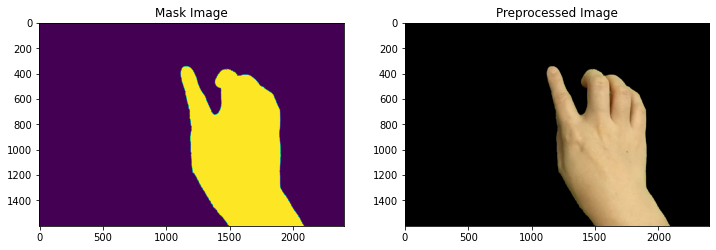

In [3]:
def preprocess(img):
    mask = compute_mask(img)  # マスクを計算する
    ret = cv2.bitwise_and(img, img, mask=mask)  # 元画像にマスクを合成する

    return mask, ret

def compute_mask(img):
    # YCrCb 色空間に変換
    imgYCrCb = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2YCrCb)
    # ぼかしをかける
    imgYCrCb = cv2.GaussianBlur(imgYCrCb, ksize=(3, 3), sigmaX=0)

    # 手の部分をくり抜く
    mask = cv2.inRange(
        src=imgYCrCb,
        lowerb=np.array([0, 135, 85]),
        upperb=np.array([255, 255, 135]),
    )
    # ノイズ除去
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    return mask

mask, prep = preprocess(src)

# マスクと前処理済みの画像を表示する
fig, axes = plt.subplots(1, 2, figsize=(12.0, 6.0))
fig.subplots_adjust(wspace=0.2, hspace=-0.2)
axes[0].imshow(mask)
axes[0].set_title('Mask Image')
axes[1].imshow(prep)
axes[1].set_title('Preprocessed Image')

## 3. エッジを検出する
手指をくり抜いた画像から手指のエッジ（縁）を検出した画像 (`edges`) を作ります。手の輪郭が青白い線として表示されるはずです。

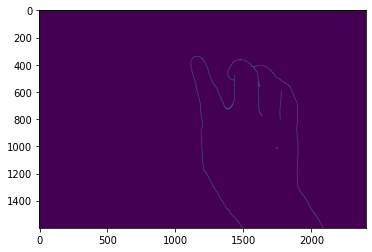

In [4]:
# Canny 法でエッジ検出を行う
def detect_edges(img):
    return cv2.Canny(img, threshold1=100, threshold2=200, L2gradient=True)

edges = detect_edges(prep)

plt.imshow(edges)

## 4. 輪郭線を抽出する
最後に、エッジ画像から輪郭線 (`contours`) を抽出します。実行後に表示される画像は、抽出した輪郭線の情報を画像として再構成したものです。これを見ると、エッジ画像から輪郭線が抽出されていることが分かると思います。

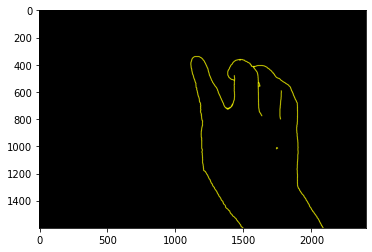

In [5]:
# This is a modified version of Munawwar Firoz's work.
# ref. https://www.codepasta.com/computer-vision/2016/11/06/background-segmentation-removal-with-opencv.html

def find_contours(edges, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE, threshold=0):
    contours, hierarchies = cv2.findContours(edges, mode=mode, method=method)

    # find level 1 contours
    hierarchy = hierarchies[0]

    # find the contours with large surface area
    significants = []
    for contour, h in zip(contours, hierarchy):
        nxt, prev, first_child, parent = h
        # filter the ones without parent
        if parent < 0:
            area = cv2.contourArea(contour)
            if area > threshold:
                significants.append((contour, area))

    significants.sort(key=lambda x: x[1], reverse=True)

    return [s[0] for s in significants]

def draw_contours(src, contours):
    contour_img = np.zeros_like(src)
    for contour in contours:
        cv2.drawContours(
            image=contour_img,
            contours=[contour],
            contourIdx=0,
            color=(255, 255, 0),
            thickness=3,
            lineType=cv2.LINE_AA,
            maxLevel=1,
        )
    return contour_img

contours = find_contours(edges)

contours_img = draw_contours(src, contours)
plt.imshow(contours_img)

## 5. まとめ
これで、撮影した写真から自動的に手指の輪郭を取り出すことができました。ここまでの結果を並べて表示してみましょう。

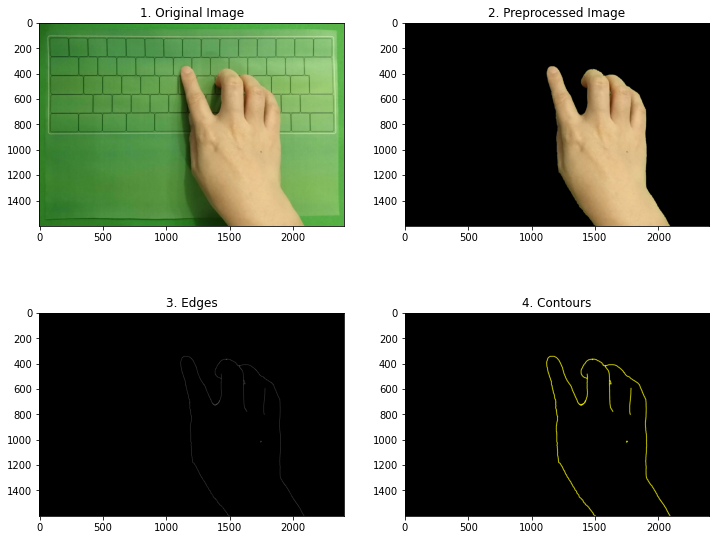

In [6]:
images = [
    (src, '1. Original Image'),
    (prep, '2. Preprocessed Image'),
    (edges, '3. Edges'),
    (contours_img, '4. Contours'),
]

fig, axes = plt.subplots(2, 2, figsize=(12.0, 12.0))
fig.subplots_adjust(wspace=0.2, hspace=-0.2)
for e, ax in zip(images, axes.flatten()):
    img, label = e
    ax.imshow(img, cmap='gray')
    ax.set_title(label)